<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#sonar-Data" data-toc-modified-id="sonar-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>sonar Data</a></span></li><li><span><a href="#Plot-Data" data-toc-modified-id="Plot-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plot Data</a></span></li><li><span><a href="#Plot-Kernels" data-toc-modified-id="Plot-Kernels-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot Kernels</a></span></li></ul></li><li><span><a href="#BEMKL" data-toc-modified-id="BEMKL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BEMKL</a></span><ul class="toc-item"><li><span><a href="#Non-Sparse" data-toc-modified-id="Non-Sparse-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Non-Sparse</a></span></li><li><span><a href="#Data-Sparse" data-toc-modified-id="Data-Sparse-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Sparse</a></span></li><li><span><a href="#Kernel-Sparse" data-toc-modified-id="Kernel-Sparse-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Kernel Sparse</a></span></li><li><span><a href="#Sparsity-Plots" data-toc-modified-id="Sparsity-Plots-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sparsity Plots</a></span></li><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Running-time-/-Number-of-Kernels" data-toc-modified-id="Running-time-/-Number-of-Kernels-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Running time / Number of Kernels</a></span></li><li><span><a href="#Running-time-/-Data-Size" data-toc-modified-id="Running-time-/-Data-Size-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Running time / Data Size</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd

import scipy as sc
from scipy.io import loadmat

import numpy as np

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

from matplotlib import pyplot as plt
%matplotlib inline

import time

import util
from util import *
import plot
import bemkl_binary

np.random.seed(123)

# Prepare Data

1. Features: 
   - kernel of all features
   - kernel of each feature
   - gaussian, polynomial 
2. Features preprocessing:
   - normalization of the features
   - spherical normalization of kernel matrices
3. Kernel Preprocessing


## sonar Data

In [2]:
reload(util)
np.random.seed(123)


X_sonar, y_sonar  = util.get_sonar_data(shuffle=True)
X_sonar = util.preprocess_feats(X_sonar)

N = int(X_sonar.shape[0]*.75)

K_sonar = util.get_kernels(X_sonar, poly=True, feat_kernel=True, gauss=True, max_gauss_width=3, min_gauss_width=-1)

K_sonar = util.preprocess_kernel(K_sonar)
K, K_test = K_sonar[:,:N,:N],K_sonar[:,N:,:N]
y, y_test = y_sonar[:N], y_sonar[N:]

In [6]:
P = K.shape[0]
print 'Number of Kernels:', P
print 'Number of Data Points:', X_sonar.shape[0]
print 'Number of Training Ponts:', N

Number of Kernels: 488
Number of Data Points: 208
Number of Training Ponts: 156


## Plot Data

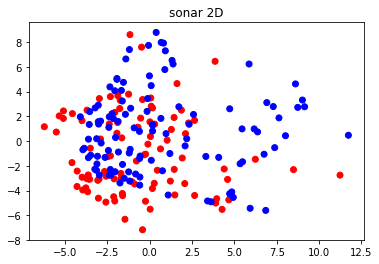

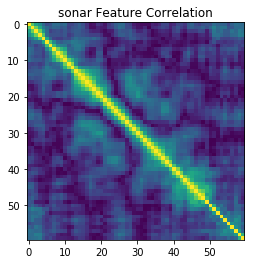

In [6]:
plot.plot_data(X_sonar,y_sonar, 'sonar')

## Plot Kernels

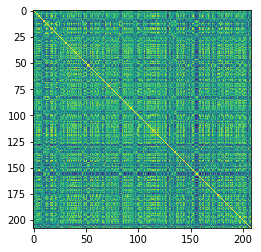

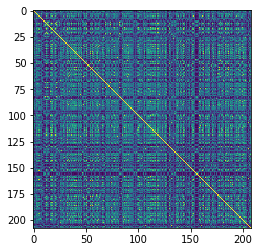

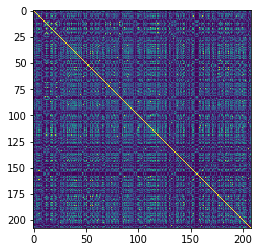

In [8]:
for i in range(3):
    plot.plot_kernel(K_sonar[i,...],'sonar_k%d'%i)

# BEMKL

## Non-Sparse

In [7]:
'''
One time Evaluation 
'''
nsp_clf = bemkl_binary.BEMKL(sparse=False)

t1 = time.time()

nsp_clf.bemkl_binary(K,y)

t2 = time.time()
diff = t2 - t1

pred, prob = nsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8461538461538461
Training Time: 57.9872720242


In [15]:
print 'Sparsity Results:'
nsp_clf.report_results()

Sparsity Results:
Nmber of Chosen Kernels:
449
Nmber of Chosen Points:
74


## Data Sparse

In [9]:
reload(bemkl_binary)

dsp_clf = bemkl_binary.BEMKL(data_sparse=True)

t1 = time.time()

dsp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = dsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.7307692307692307
Training Time: 61.8797008991


In [10]:
print 'Sparsity Results:'
dsp_clf.report_results()

Sparsity Results:
Nmber of Chosen Kernels:
474
Nmber of Chosen Points:
6


## Kernel Sparse

In [11]:
sp_clf = bemkl_binary.BEMKL(sparse=True)

t1 = time.time()

sp_clf.bemkl_binary(K,y)

t2 = time.time()
diff = t2 - t1

pred, prob = sp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.6730769230769231
Training Time: 57.8196201324


In [12]:
print 'Sparsity Results'
sp_clf.report_results()

Sparsity Results
Nmber of Chosen Kernels:
26
Nmber of Chosen Points:
156


## Sparsity Plots

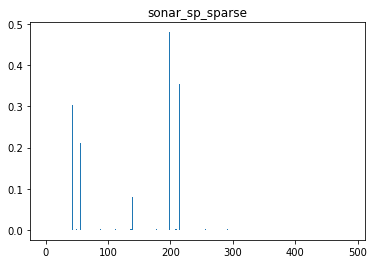

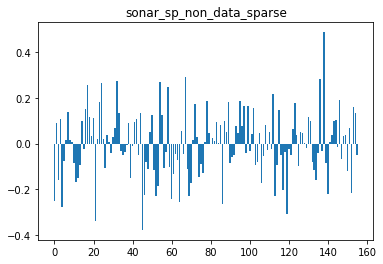

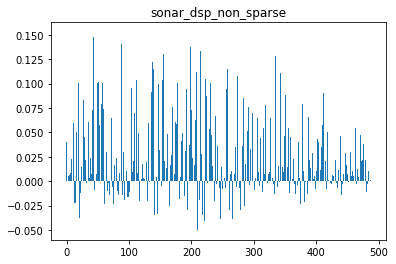

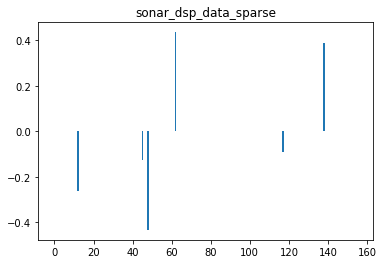

In [7]:
plot.plot_results(sp_clf, 'sonar_sp')
plot.plot_results(dsp_clf, 'sonar_dsp')

## Cross Validation

In [23]:
print 'Cross Validation Results for Non-Sparse model:'
nsp_clf = bemkl_binary.BEMKL(sparse=False)
nsp_clf.evaluate_model(K_sonar,y_sonar)

print 'Cross Validation Results for Kernel-Sparse model:'
sp_clf = bemkl_binary.BEMKL(sparse=True)
sp_clf.evaluate_model(K_sonar,y_sonar)

print 'Cross Validation Results for Data-Sparse model:'
dsp_clf = bemkl_binary.BEMKL(data_sparse=True)
dsp_clf.evaluate_model(K_sonar,y_sonar)

Cross Validation Results for Non-Sparse model:
Mean Accuracy: 0.8464576074332172
Cross Validation Results for Kernel-Sparse model:
Mean Accuracy: 0.7450638792102205
Cross Validation Results for Data-Sparse model:
Mean Accuracy: 0.7790940766550521


## Running time / Number of Kernels

In [ ]:
times = []

for i in range(20, K_sonar.shape[0], 20):
    nsp_clf = bemkl_binary.BEMKL(sparse=False)

    t1 = time.time()

    nsp_clf.bemkl_binary(K[:i,...],y)

    t2 = time.time()
    diff = t2 - t1
    
    times.append([i, diff])


Text(0.5,1,'Sonar: training time/#kernels')

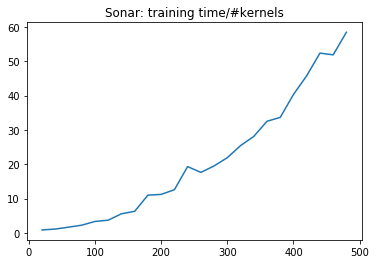

In [7]:
times_ = np.asarray(times)

fig = plt.figure()
plt.plot(times_[:,0],times_[:,1])
plt.title("Sonar: training time/#kernels")

fig.savefig('sonar_time_kernel.png' , dpi=400, transparent=True, bbox_inches='tight')

## Running time / Data Size

In [ ]:
times2 = []

for i in range(20, X_sonar.shape[0], 20):
    nsp_clf = bemkl_binary.BEMKL(sparse=False)

    t1 = time.time()

    nsp_clf.bemkl_binary(K_sonar[:,:i,:i],y_sonar[:i])

    t2 = time.time()
    diff = t2 - t1
    
    times2.append([i, diff])

times2

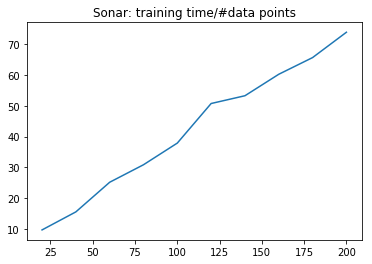

In [11]:
times_ = np.asarray(times2)

fig = plt.figure()
plt.plot(times_[:,0],times_[:,1])
plt.title("Sonar: training time/#data points")

fig.savefig('sonar_time_data.png' , dpi=400, transparent=True, bbox_inches='tight')